In [1]:
from ema_workbench import (RealParameter, IntegerParameter, ScalarOutcome, Constant,
                           Model, ema_logging, perform_experiments)

#from dps_lake_model import lake_model

import os
import subprocess
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
def func_precision(stringList, answer):
    goal_count = 0
    found = 0
    for result in stringList:
        if result == str(answer):
            found = 1
        goal_count += 1
    return found/(goal_count-1)

def func_recall(stringList, answer):
    found = 0
    for result in stringList:
        if result == str(answer):
            found = 1
            break
    return found

def func_accuracy(total, stringList, answer):
    tp = 0
    tn = 0
    fp = 0
    fn = 0
    for result in stringList[0:-1]:
        if result == str(answer):
            tp += 1
        else:
            fp += 1
    
    fn = 1 - tp
    
    # total is the number of all goals
    tn = total - tp - fp - fn
    return (tp + tn)/(tn + tp + fp + fn)


def calculate_statistics():
    data = pd.read_csv("./outputs/sokoban.csv")
    length = data.shape[0]
    num = 0
    
    precision = 0
    recall = 0
    accuracy = 0
    
    for index in range(length):

        answer = data.loc[index, "Real_Goal"]
        results = data.loc[index, "Results"].split("/")
        all_candidates = data.loc[index, "Cost"].split("/")
        
        total = len(all_candidates)-1   # the last one is /
        
        p = func_precision(results, answer)
        r = func_recall(results, answer)
        a = func_accuracy(total, results, answer)
        
        num += 1
        
        precision += p
        recall += r
        accuracy += a
        
    num += 1
    precision = precision/num
    recall = recall/num
    accuracy = accuracy/num 
    
    return precision, recall, accuracy
        
    
    

def gr_system(phi, lamb, delta):
    # run GR with phi lamb delta
    os.chdir("./tools/")
    os.system("java -jar gr_ipc.jar ../gene_data/ sokoban %s %s %s" %(str(phi), str(lamb), str(delta)))
    os.chdir("../")
    # calculate p r a
    
    # print("passed")
    precision, recall, accuracy = calculate_statistics()
    
    return precision, recall, accuracy
    

In [3]:
ema_logging.LOG_FORMAT = '[%(name)s/%(levelname)s/%(processName)s] %(message)s'
ema_logging.log_to_stderr(ema_logging.INFO)
    
model = Model('grsystem', function=gr_system)

# set levers
model.uncertainties = [IntegerParameter("phi", 0,100),
                RealParameter("delta", 0, 2),
                RealParameter("lamb", 1, 2)]

#specify outcomes
model.outcomes = [ScalarOutcome('precision'),
                  ScalarOutcome('recall'),
                  ScalarOutcome('accuracy')]

results = perform_experiments(model, 100)

[EMA.ema_workbench.em_framework.evaluators/INFO/MainProcess] performing 100 scenarios * 1 policies * 1 model(s) = 100 experiments
[EMA.ema_workbench.em_framework.evaluators/INFO/MainProcess] performing experiments sequentially
[EMA.ema_workbench.em_framework.callbacks/INFO/MainProcess] 10 cases completed
[EMA.ema_workbench.em_framework.callbacks/INFO/MainProcess] 20 cases completed
[EMA.ema_workbench.em_framework.callbacks/INFO/MainProcess] 30 cases completed
[EMA.ema_workbench.em_framework.callbacks/INFO/MainProcess] 40 cases completed
[EMA.ema_workbench.em_framework.callbacks/INFO/MainProcess] 50 cases completed
[EMA.ema_workbench.em_framework.callbacks/INFO/MainProcess] 60 cases completed
[EMA.ema_workbench.em_framework.callbacks/INFO/MainProcess] 70 cases completed
[EMA.ema_workbench.em_framework.callbacks/INFO/MainProcess] 80 cases completed
[EMA.ema_workbench.em_framework.callbacks/INFO/MainProcess] 90 cases completed
[EMA.ema_workbench.em_framework.callbacks/INFO/MainProcess] 10

[EMA.ema_workbench.analysis.feature_scoring/INFO/MainProcess] policy dropped from analysis because only a single category
[EMA.ema_workbench.analysis.feature_scoring/INFO/MainProcess] model dropped from analysis because only a single category
[EMA.ema_workbench.analysis.feature_scoring/INFO/MainProcess] policy dropped from analysis because only a single category
[EMA.ema_workbench.analysis.feature_scoring/INFO/MainProcess] model dropped from analysis because only a single category
[EMA.ema_workbench.analysis.feature_scoring/INFO/MainProcess] policy dropped from analysis because only a single category
[EMA.ema_workbench.analysis.feature_scoring/INFO/MainProcess] model dropped from analysis because only a single category


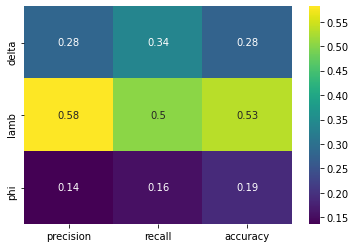

In [4]:
from ema_workbench.analysis import feature_scoring
experiments, outcomes = results
x = experiments
y = outcomes

fs = feature_scoring.get_feature_scores_all(x, y)
sns.heatmap(fs, cmap='viridis', annot=True)
plt.show()

[EMA.ema_workbench.analysis.plotting_util/INFO/MainProcess] no time dimension found in results


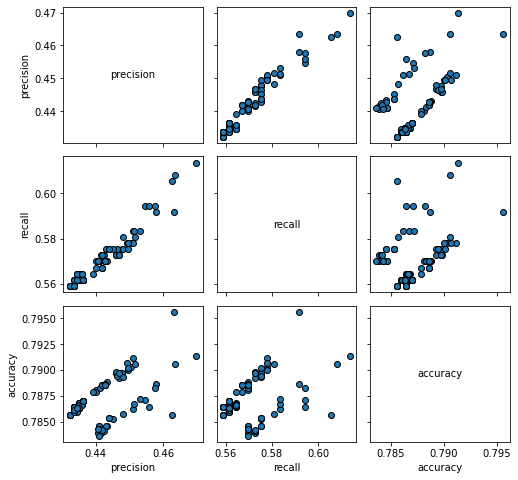

In [5]:
from ema_workbench.analysis import pairs_plotting

fig, axes = pairs_plotting.pairs_scatter(experiments, outcomes, group_by='policy',
                                         legend=False)
fig.set_size_inches(8,8)
plt.show()

In [6]:
from ema_workbench import save_results
save_results(results, '100_scenarios_sokoban.tar.gz')

#from ema_workbench import load_results
#results = load_results('100_scenarios_blocks_world.tar.gz')

[EMA.ema_workbench.util.utilities/INFO/MainProcess] results saved successfully to /Users/zihangs/eclipse-workspace/GR_system/100_scenarios_sokoban.tar.gz


In [8]:
from SALib.analyze import sobol
from ema_workbench.em_framework.salib_samplers import get_SALib_problem
from ema_workbench import (MultiprocessingEvaluator, ema_logging,
                           perform_experiments)

ema_logging.log_to_stderr(ema_logging.INFO)


sa_results = perform_experiments(model, scenarios=40, uncertainty_sampling='sobol')

experiments, outcomes = sa_results
save_results(results, '40_scenarios_sokoban_sobol.tar.gz')

[EMA.ema_workbench.em_framework.evaluators/INFO/MainProcess] performing 320 scenarios * 1 policies * 1 model(s) = 320 experiments
[EMA.ema_workbench.em_framework.evaluators/INFO/MainProcess] performing experiments sequentially
[EMA.ema_workbench.em_framework.callbacks/INFO/MainProcess] 32 cases completed
[EMA.ema_workbench.em_framework.callbacks/INFO/MainProcess] 64 cases completed
[EMA.ema_workbench.em_framework.callbacks/INFO/MainProcess] 96 cases completed
[EMA.ema_workbench.em_framework.callbacks/INFO/MainProcess] 128 cases completed
[EMA.ema_workbench.em_framework.callbacks/INFO/MainProcess] 160 cases completed
[EMA.ema_workbench.em_framework.callbacks/INFO/MainProcess] 192 cases completed
[EMA.ema_workbench.em_framework.callbacks/INFO/MainProcess] 224 cases completed
[EMA.ema_workbench.em_framework.callbacks/INFO/MainProcess] 256 cases completed
[EMA.ema_workbench.em_framework.callbacks/INFO/MainProcess] 288 cases completed
[EMA.ema_workbench.em_framework.callbacks/INFO/MainProce

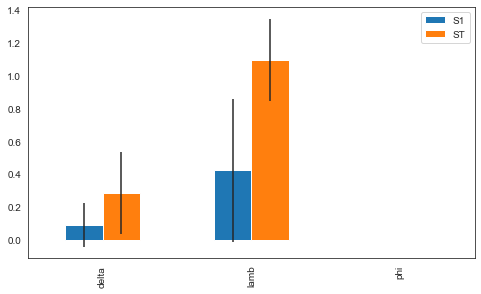

In [9]:
problem = get_SALib_problem(model.uncertainties)
Si = sobol.analyze(problem, outcomes['accuracy'],
                   calc_second_order=True, print_to_console=False)

scores_filtered = {k:Si[k] for k in ['ST','ST_conf','S1','S1_conf']}
Si_df = pd.DataFrame(scores_filtered, index=problem['names'])

sns.set_style('white')
fig, ax = plt.subplots(1)

indices = Si_df[['S1','ST']]
err = Si_df[['S1_conf','ST_conf']]

indices.plot.bar(yerr=err.values.T,ax=ax)
fig.set_size_inches(8,6)
fig.subplots_adjust(bottom=0.3)
plt.show()